<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [63]:
# Set your student number
student_number = 99102507
Name = 'Amir Hossein'
Last_Name = 'Yari'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [64]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [65]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [66]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [67]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

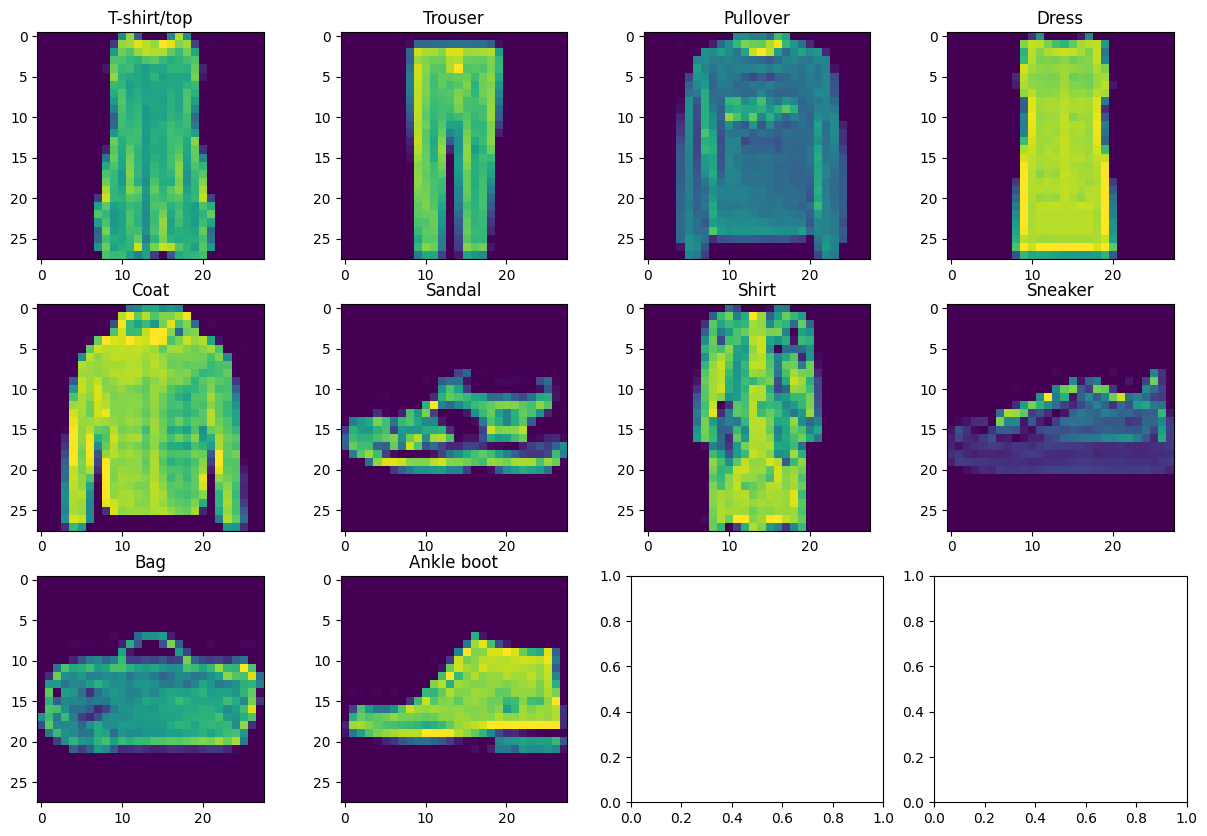

In [68]:
## FILL HERE
classes = train_set.classes

class_num = len(classes)

# Initialize images
images = {}
for i in classes:
  images[i] = None

# Visualize random image from each class
for img, lbl in train_loader:
  for i in range(len(lbl)):
    indexes = lbl[i].item()
    if images[classes[indexes]] is None:
      images[classes[indexes]] = img[i]
  if all([j is not None for j in images.values()]):
    break

# Plotting
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(class_num):
  axs[divmod(i, 4)].imshow(images[classes[i]].permute(1, 2, 0))
  axs[divmod(i, 4)].set_title(classes[i])

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [69]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [70]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [71]:
def affine_forward(x, w, b):
    return torch.matmul(x, w) + b


def relu(x):
    return torch.maximum(x, torch.tensor(0.0))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [72]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    output = x
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        output = affine_forward(output, w, b)
        output = relu(output)
    return output

Implementing cross entropy loss:

In [74]:
def cross_entropy_loss(scores, y):
    n = len(y)
    probablity = torch.exp(scores) / torch.sum(torch.exp(scores), axis=1, keepdims=True)
    return 1/n * torch.sum(-1 * torch.log(probablity[range(n), y]))

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [75]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    for i in parameters.values():
        i.data = i.data - learning_rate * i.grad.data
        i.grad.data.zero_()

Training functions:

In [77]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    return 100*np.mean(y_pred == y_true)

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using loss.backward() method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        loss = cross_entropy_loss(p, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        train_loss += loss.item() * x.shape[0]/N_train 
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    print(f'Epoch [{epoch+1}], Train Loss: {loss.item():.4f}') 

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item() * x.shape[0]
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    print(f'Epoch [{epoch+1}], Validate Loss: {loss.item():.4f}')
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [78]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [80]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate=learning_rate, epoch=epoch)
        test_loss, test_acc = validate(test_loader, epoch=epoch, set_name='test')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Plotting
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, 'r', label='train')
    plt.plot(test_losses, 'b', label='test')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.title('History Of Loss')
    plt.legend()

    #Plotting
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, 'c', label='train')
    plt.plot(test_accuracies, 'm', label='test')
    plt.xlabel('epochs')
    plt.ylabel('accuracies')
    plt.title('History of Accuracy')
    plt.legend()

    plt.savefig(f'History of {model_name}.png')
    plt.show()

Epoch [1], Train Loss: 2.2701
Accuracy of train set: 34.089999999999996
Epoch [1], Validate Loss: 2.2747
Accuracy of test set: 48.06
Epoch [2], Train Loss: 1.9982
Accuracy of train set: 46.318333333333335
Epoch [2], Validate Loss: 2.1172
Accuracy of test set: 38.04833333333333
Epoch [3], Train Loss: 1.2780
Accuracy of train set: 45.41833333333333
Epoch [3], Validate Loss: 1.3083
Accuracy of test set: 55.071666666666665
Epoch [4], Train Loss: 0.7531
Accuracy of train set: 58.209999999999994
Epoch [4], Validate Loss: 0.9440
Accuracy of test set: 59.961666666666666
Epoch [5], Train Loss: 0.9684
Accuracy of train set: 63.391666666666666
Epoch [5], Validate Loss: 0.5941
Accuracy of test set: 66.0
Epoch [6], Train Loss: 0.9644
Accuracy of train set: 66.76666666666667
Epoch [6], Validate Loss: 0.7274
Accuracy of test set: 67.54333333333334
Epoch [7], Train Loss: 1.1874
Accuracy of train set: 68.99833333333333
Epoch [7], Validate Loss: 0.6284
Accuracy of test set: 69.75333333333333
Epoch [8], 

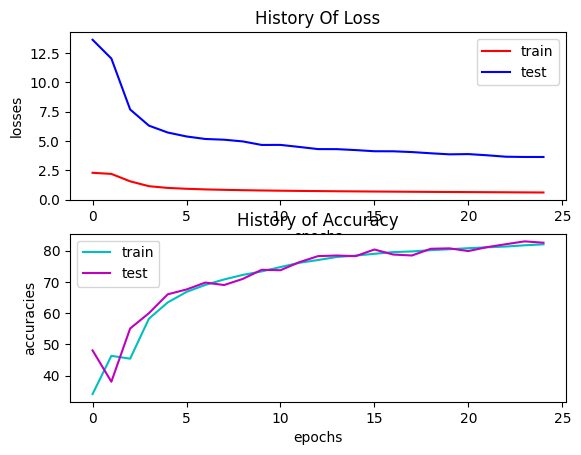

In [81]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [82]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 82.49333333333333


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

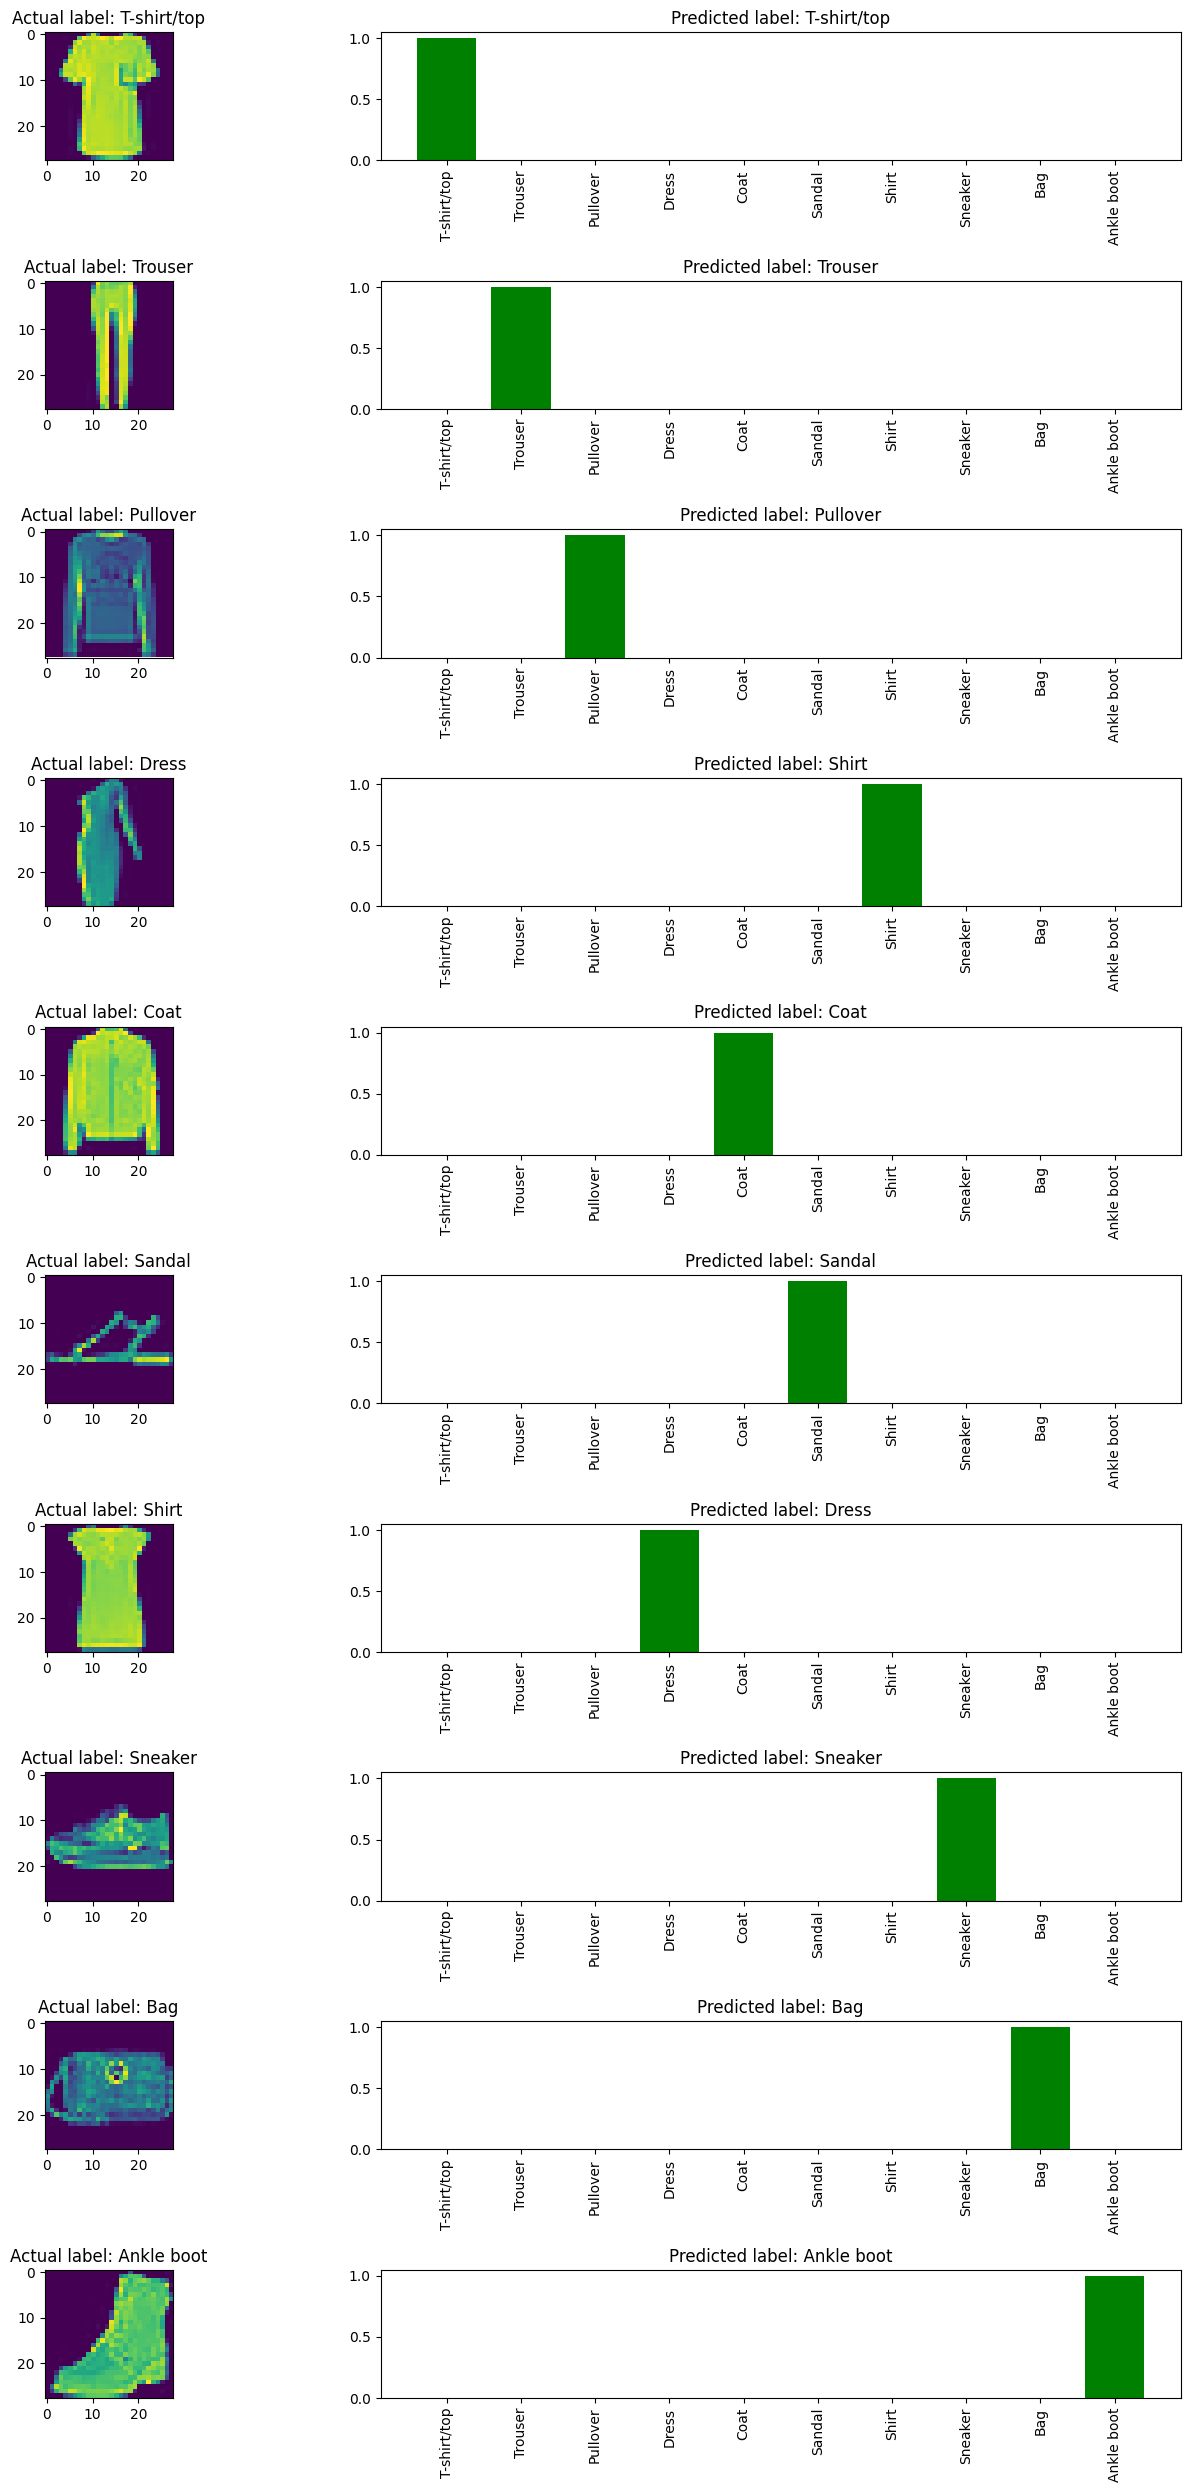

In [97]:
test_classes = test_set.classes
counter = {}
images = {}
predictions = {}

with torch.no_grad():
    for k in test_loader:
        img, lbl = k
        outputs = model(img, parameters)
        _, predicted = torch.max(outputs, 1)
        for i in range(img.shape[0]):
            label = lbl[i].item()
            predict = predicted[i].item()
            if label not in images:
                counter[label] = i
                images[label] = img[i]
                predictions[label] = predict
            if len(images) == 10:
                break
        if len(images) == 10:
            break

# Plotting
fig, axs = plt.subplots(nrows=num_classes, ncols=2, figsize=(15, 25))
for i in range(num_classes):
    axs[i, 0].imshow(images[i].permute(1, 2, 0))
    axs[i, 0].set_title(f'Actual label: {test_classes[i]}')
    axs[i, 1].set_title(f'Predicted label: {test_classes[predictions[i]]}')
    max_index = np.argmax(outputs[counter[i]])
    output_vec = np.zeros_like(outputs[counter[i]])
    output_vec[max_index] = 1
    axs[i, 1].bar(range(num_classes), output_vec, color='g')
    axs[i, 1].set_xticks(range(num_classes))
    axs[i, 1].set_xticklabels(test_classes, rotation=90)
fig.tight_layout(pad=1.0)
plt.show()